### Grading Feedback
96%

# IST 718: Big Data Analytics

- Professor: Willard Williamson <wewillia@syr.edu>
- Faculty Assistant: Yash Pasar <yspasar@syr.edu>
## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers from your classmates.  Short code snippets are allowed from the internet.  Code from the class text books or class provided code can be copied in its entirety.__
- There could be tests in some cells (i.e., `assert` and `np.testing.` statements). These tests (if present) are used to grade your answers. **However, the professor and FAs could use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before submitting your work, remember to check for run time errors with the following procedure:
`Kernel`$\rightarrow$`Restart and Run All`.  All runtime errors will result in a minimum penalty of half off.
- Data Bricks is the official class runtime environment so you should test your code on Data Bricks before submission.  If there is a runtime problem in the grading environment, we will try your code on Data Bricks before making a final grading decision.
- All plots shall include a title, and axis labels.
- Grading feedback cells are there for graders to provide feedback to students.  Don't change or remove grading feedback cells.
- Don't add or remove files from your git repo.
- Do not change file names in your repo.  This also means don't change the title of the ipython notebook.
- You are free to add additional code cells around the cells marked `your code here`.
- Students may use toPandas() to print the head of data frames.
- __Only use spark, spark machine learning, spark data frames, RDD's, and map reduce to solve all problems unless instructed otherwise.__

In [1]:
# Do not delete or change this cell

import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.sql.functions import regexp_replace
from pyspark.sql import functions as fn
import requests
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import length
from pyspark.sql import Row


spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

# Question 1
Using the get_training_filename function defined in the cell above, read the sms_spam.csv file into a spark dataframe named spam_df.  There should be no empty columns in spam_df.

In [3]:
# Your code here

spam_df = spark.read.option("header","true").option("delimiter",",").option("inferSchema","true").csv(get_training_filename('sms_spam.csv'))
spam_df.show()

print('Shape of spam_df = ',(spam_df.count(), len(spam_df.columns)))

+----+--------------------+
|type|                text|
+----+--------------------+
| ham|Go until jurong p...|
| ham|Ok lar... Joking ...|
|spam|Free entry in 2 a...|
| ham|U dun say so earl...|
| ham|Nah I don't think...|
|spam|FreeMsg Hey there...|
| ham|Even my brother i...|
| ham|As per your reque...|
|spam|WINNER!! As a val...|
|spam|Had your mobile 1...|
| ham|I'm gonna be home...|
|spam|SIX chances to wi...|
|spam|URGENT! You have ...|
| ham|I've been searchi...|
| ham|I HAVE A DATE ON ...|
|spam|XXXMobileMovieClu...|
| ham|Oh k...i'm watchi...|
| ham|Eh u remember how...|
| ham|Fine if that's th...|
|spam|England v Macedon...|
+----+--------------------+
only showing top 20 rows

Shape of spam_df =  (5574, 2)


### Grading Feedback
-3 runtime error fixed by grader

# Question 2
Starting with spam_df, create a new dataframe named spam_df1.  Rename the spam_df type column to be named spam.  In the spam column, replace the string `spam` the with the integer 1 and the string `ham` with the integer 0.  Print the head and shape of spam_df1.

In [4]:
# your code here

spam_df1 = spam_df.select(col('type').alias('spam'),col('text'))


spam_df1 = spam_df1.withColumn('spam', regexp_replace('spam','spam','1')).withColumn('spam', regexp_replace('spam','ham','0'))

spam_df1 = spam_df1.select(col('spam').cast('int'),col('text'))

spam_df1.printSchema()

print('Shape of spam_df1 = ',(spam_df1.count(), len(spam_df1.columns)))

spam_df1.show(5)

root
 |-- spam: integer (nullable = true)
 |-- text: string (nullable = true)

Shape of spam_df1 =  (5574, 2)
+----+--------------------+
|spam|                text|
+----+--------------------+
|   0|Go until jurong p...|
|   0|Ok lar... Joking ...|
|   1|Free entry in 2 a...|
|   0|U dun say so earl...|
|   0|Nah I don't think...|
+----+--------------------+
only showing top 5 rows



# Question 3
Starting with spam_df1, create a new dataframe named spam_df2 with a new column named filtered_text by removing stop words from the text column in spam_df.  Print the head and shape of spam_df2.

In [5]:
# your code here

tokenizer = RegexTokenizer().setGaps(False)\
  .setPattern("\\p{L}+")\
  .setInputCol("text")\
  .setOutputCol("tokens")


stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()

sw_filter = StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("tokens")\
  .setOutputCol("filtered_text")

cv_pipeline = Pipeline(stages=[tokenizer, sw_filter]).fit(spam_df1)

filt_text = cv_pipeline.transform(spam_df1)

spam_df2 = filt_text.select('spam','text','filtered_text')

spam_df2.show(5)

print('Shape of spam_df2  = ',(spam_df2.count(), len(spam_df2.columns)))

+----+--------------------+--------------------+
|spam|                text|       filtered_text|
+----+--------------------+--------------------+
|   0|Go until jurong p...|[jurong, point, c...|
|   0|Ok lar... Joking ...|[ok, lar, joking,...|
|   1|Free entry in 2 a...|[free, entry, wkl...|
|   0|U dun say so earl...|[u, dun, say, ear...|
|   0|Nah I don't think...|[nah, don, t, thi...|
+----+--------------------+--------------------+
only showing top 5 rows

Shape of spam_df2  =  (5574, 3)


### Grading Feedback

# Question 3
Create a new dataframe named spam_df3 starting with spam_df2.  Create a new column named tfidf by performing a term frequency / inverse document frequency transformation on the filtered_text column of spam_df2.<br>  

- Print the head and shape of spam_df3.  
- Print the top 10 most important words indicated by the TFIDF score.  
- Print the 10 least important words as indicated by the TFIDF score.
- Print the total number of columns in the TFIDF data in spam_df3
- Print the number of rows in the TFIDF data in spam_df3
- Based only on the number of rows and columns in the TFIDF data, do you expect the model to overfit.  Explain your answer.

In [6]:
# Your code here

cv = CountVectorizer(vocabSize=2**17)\
  .setInputCol("filtered_text")\
  .setOutputCol("termfreq")

cv_pipeline_new = Pipeline(stages=[cv]).fit(spam_df2)


idf = IDF().\
    setInputCol('termfreq').\
    setOutputCol('tfidf')

idf_pipeline = Pipeline(stages=[cv_pipeline_new, idf]).fit(spam_df2)


spam_df3 = idf_pipeline.transform(spam_df2)
spam_df3.show(5)

+----+--------------------+--------------------+--------------------+--------------------+
|spam|                text|       filtered_text|            termfreq|               tfidf|
+----+--------------------+--------------------+--------------------+--------------------+
|   0|Go until jurong p...|[jurong, point, c...|(7443,[15,26,52,6...|(7443,[15,26,52,6...|
|   0|Ok lar... Joking ...|[ok, lar, joking,...|(7443,[0,8,216,32...|(7443,[0,8,216,32...|
|   1|Free entry in 2 a...|[free, entry, wkl...|(7443,[1,2,9,21,2...|(7443,[1,2,9,21,2...|
|   0|U dun say so earl...|[u, dun, say, ear...|(7443,[0,50,75,13...|(7443,[0,50,75,13...|
|   0|Nah I don't think...|[nah, don, t, thi...|(7443,[2,30,46,33...|(7443,[2,30,46,33...|
+----+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [7]:
idf_pipeline.stages[-1].idf

DenseVector([1.8915, 2.3665, 2.6026, 2.5763, 2.8959, 2.7372, 3.133, 3.133, 2.9913, 3.1707, 3.0731, 3.1167, 3.1793, 3.1923, 3.2324, 3.188, 3.2462, 3.2789, 3.4556, 3.353, 3.379, 3.4499, 3.4443, 3.4961, 3.5021, 3.6988, 3.6493, 3.5826, 3.5385, 3.5141, 3.6424, 3.6844, 3.6424, 3.5509, 3.6022, 3.7662, 3.7134, 3.7134, 4.0309, 3.7208, 3.7509, 3.7134, 3.8386, 3.7282, 3.7357, 3.9165, 3.7585, 3.8469, 3.7898, 3.9165, 3.8469, 3.8811, 3.9347, 3.9532, 3.9165, 3.9347, 3.9347, 3.9075, 3.9075, 4.0109, 4.1601, 3.9913, 3.9817, 4.0309, 4.0209, 4.0109, 4.0411, 4.0617, 4.1487, 4.0934, 4.0828, 4.0617, 4.1834, 4.1152, 4.1601, 4.1374, 4.1952, 4.2566, 4.2316, 4.1374, 4.1601, 4.3634, 4.1952, 4.2822, 4.2953, 4.2316, 4.4065, 4.2822, 4.2693, 4.2822, 4.2953, 4.322, 4.322, 4.3086, 4.3494, 4.5656, 4.3086, 4.3494, 4.3494, 4.3919, 4.3776, 4.4065, 4.4517, 4.3919, 4.4829, 4.6007, 4.4364, 4.4672, 4.4672, 4.583, 4.6371, 4.5317, 4.5317, 4.4829, 4.5152, 4.5485, 4.8648, 4.5152, 4.583, 4.5485, 4.6558, 4.5317, 4.5656, 4.5485, 4.69

In [8]:
print('Total number of columns in the TFIDF data  = ',len(idf_pipeline.stages[0].stages[-1].vocabulary))

Total number of columns in the TFIDF data  =  7443


In [9]:
print('Total number of rows in the TFIDF data  = ',spam_df3.select('tfidf').count())

Total number of rows in the TFIDF data  =  5574


In [10]:
vocabulary = idf_pipeline.stages[0].stages[-1].vocabulary
weights = idf_pipeline.stages[-1].idf.toArray()
coeffs_df = pd.DataFrame({'word': vocabulary, 'weight': weights})

10 least important words as indicated by the TFIDF score

In [11]:
coeffs_df.sort_values('weight').head(10)

,word,weight
0,u,1.891456
1,s,2.366466
3,m,2.576314
2,t,2.602600
5,just,2.737170
4,ur,2.895948
8,ok,2.991258
10,ll,3.073088
11,know,3.116659
6,gt,3.132986


10 most important words as indicated by the TFIDF score

In [12]:
coeffs_df.sort_values('weight',ascending=False).head(10)

,word,weight
3721,dena,7.9329
4958,aq,7.9329
4970,belt,7.9329
4969,ettans,7.9329
4968,myparents,7.9329
4967,gained,7.9329
4966,rough,7.9329
4965,steps,7.9329
4964,kvb,7.9329
4963,interviw,7.9329


In [13]:
print('Shape of spam_df3 = ',(spam_df3.count(), len(spam_df3.columns)))

Shape of spam_df3 =  (5574, 5)


Your model overfit explanation here: As the number of features(size of vocabulary) in TFIDF data is greater than number of rows in the data, the model is guaranteed to overfit. This is also called curse of dimensionality where the number of predictors are greater than number of observations. So the model will overfit and is not a generalized model as it will work very good on training data but for unknown samples it will give high error. 

### Grading Feedback

# Question 4
Create a pipeline named pipe1 capable of predicting ham or spam using logistic regression using spam_df3 as input data.

In [14]:
# your code here
lr = LogisticRegression().\
    setLabelCol('spam').\
    setFeaturesCol('tfidf').\
    setRegParam(0.0).\
    setMaxIter(100).\
    setElasticNetParam(0.)

pipe1 = Pipeline(stages=[lr])

### Grading Feedback

# Question 5
Fit pipe1 using a [CrossValidator](https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) object with the number of cross validation folds = 3.  Score the model using a [BinaryClassificationEvaluator](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html) using ROC AUC as the metric.  Name the cross validator object cv1 and the fitted cross validator object fitted_cv1.

In [15]:
# your code here

evaluator = BinaryClassificationEvaluator(labelCol='spam',metricName='areaUnderROC')

grid = ParamGridBuilder().build()

cv1 = CrossValidator(estimator=pipe1,estimatorParamMaps=grid, numFolds=3, evaluator=evaluator)

fitted_cv1 = cv1.fit(spam_df3)

### Grading Feedback

# Question 6
Print the cross validation AUC score from fitted_cv1.

In [16]:
# your code here

evaluator.evaluate(fitted_cv1.transform(spam_df3))

1.0

### Grading Feedback
-3 We asked for the cross validation AUC score but you scored the model based on training data.

# Question 7
Create a ROC scatter plot from fitted_pipe1 TPR/FPR data.

In [17]:
# your code here

fpr_tpr = fitted_cv1.bestModel.stages[0].summary.roc

In [18]:
fpr = fpr_tpr.select('FPR').collect()
tpr = fpr_tpr.select('TPR').collect()

In [19]:
print(fpr)
print(tpr)

[Row(FPR=0.0), Row(FPR=0.0), Row(FPR=0.0), Row(FPR=0.0), Row(FPR=0.0), Row(FPR=0.0), Row(FPR=0.0), Row(FPR=0.0), Row(FPR=0.0), Row(FPR=0.0), Row(FPR=0.0), Row(FPR=0.008286720530350114), Row(FPR=0.02030246529935778), Row(FPR=0.03190387404184794), Row(FPR=0.043919618810855605), Row(FPR=0.054278019473793244), Row(FPR=0.0689869484151647), Row(FPR=0.07913818106484359), Row(FPR=0.08970374974103998), Row(FPR=0.10026931841723638), Row(FPR=0.11042055106691527), Row(FPR=0.12140045576962917), Row(FPR=0.13155168841930806), Row(FPR=0.1419100890822457), Row(FPR=0.15226848974518334), Row(FPR=0.163455562461156), Row(FPR=0.17381396312409364), Row(FPR=0.18437953180029004), Row(FPR=0.1959809405427802), Row(FPR=0.20675367723223534), Row(FPR=0.2175264139216905), Row(FPR=0.2285063186244044), Row(FPR=0.23886471928734204), Row(FPR=0.24922311995027968), Row(FPR=0.25999585663973485), Row(FPR=0.27056142531593125), Row(FPR=0.2817484980319039), Row(FPR=0.2921068986948415), Row(FPR=0.30246529935777916), Row(FPR=0.3

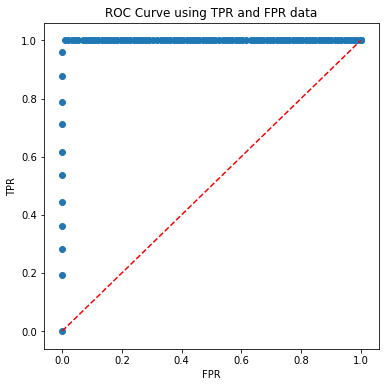

In [20]:
plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'r--')
plt.scatter(fpr,
         tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve using TPR and FPR data')
plt.show()

### Grading Feedback

# Question 8
Create a new cross validator object named cv2 similar to cv1 but this time add a ParamGridBuilder.  Define a grid of elastic net regularization parameters. Fit cv2 and name the resulting fitted cross validator fitted_cv2.  The number of parameters in your grid should be limited such that it runs in a reasonable amount of time (around 5 to 10 minutes max).  

In [21]:
# your code here


grid_new = ParamGridBuilder(). addGrid(lr.regParam, [0.01,0.02,0.05]).\
       addGrid(lr.elasticNetParam, [0.2,0.5,0.7]).\
       build()

cv2 = CrossValidator(estimator=pipe1, estimatorParamMaps=grid_new, numFolds=3, evaluator=evaluator)


fitted_cv2 = cv2.fit(spam_df3)

In [22]:
grid_new

[{Param(parent='LogisticRegression_7ee11e6cc08f', name='regParam', doc='regularization parameter (>= 0).'): 0.01,
  Param(parent='LogisticRegression_7ee11e6cc08f', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.2},
 {Param(parent='LogisticRegression_7ee11e6cc08f', name='regParam', doc='regularization parameter (>= 0).'): 0.01,
  Param(parent='LogisticRegression_7ee11e6cc08f', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5},
 {Param(parent='LogisticRegression_7ee11e6cc08f', name='regParam', doc='regularization parameter (>= 0).'): 0.01,
  Param(parent='LogisticRegression_7ee11e6cc08f', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.7},
 

### Grading feedback

# Question 9
- Print the resulting AUC from fitted_cv2. 
- Print the best model's L1 and L2 regularization parameters
- Analyze the L1 feature selection:
    - Print the total number of features
    - Print the number of features that L1 regularization eliminated
    - If any features were eliminated, print a sample of 10 words that were eliminated

In [23]:
# your code here


In [24]:
print('AUC score from fiited_cv2 cross validator is',evaluator.evaluate(fitted_cv2.transform(spam_df3)))

AUC score from fiited_cv2 cross validator is 0.9997340373163122


In [25]:
print("Best Model's L1 Regularization Parameter",fitted_cv2.bestModel.stages[0]._java_obj.getRegParam() * fitted_cv2.bestModel.stages[0]._java_obj.getElasticNetParam())
print("Best Model's L2 Regularization Parameter",fitted_cv2.bestModel.stages[0]._java_obj.getRegParam() * (1-fitted_cv2.bestModel.stages[0]._java_obj.getElasticNetParam()))

Best Model's L1 Regularization Parameter 0.002
Best Model's L2 Regularization Parameter 0.008


In [26]:
fitted_cv2.getEstimatorParamMaps()[np.argmax(fitted_cv2.avgMetrics)]

{Param(parent='LogisticRegression_7ee11e6cc08f', name='regParam', doc='regularization parameter (>= 0).'): 0.01,
 Param(parent='LogisticRegression_7ee11e6cc08f', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.2}

In [27]:
coef_best = fitted_cv2.bestModel.stages[0].coefficients.toArray()

In [28]:
abs_weights  = abs(coef_best)

print('Total number of features are',len(abs_weights))

sorted_abs = np.sort(abs_weights)

weights_notzero = sorted_abs[sorted_abs != 0]
nonzero_weights = len(sorted_abs[sorted_abs != 0])

print('Eliminated features out of 7443 are', nonzero_weights)

Total number of features are 7443
Eliminated features out of 7443 are 577


In [29]:
vocabulary = idf_pipeline.stages[0].stages[-1].vocabulary

coeffs_df_dict = {'word': vocabulary, 'weight': abs_weights}

coeffs_df1 = pd.DataFrame({'word': vocabulary, 'weight': abs_weights})

In [30]:
eleminated_words_weights = coeffs_df1[coeffs_df1['weight']==0]

eleminated_words = eleminated_words_weights.iloc[0:,0:1]

words_zero_weig = str(eleminated_words['word'].tolist())[1:-1]

len(words_zero_weig)

print('Sample of 10 Eliminated words are', words_zero_weig[0:62])

Sample of 10 Eliminated words are 'u', 's', 't', 'm', 'ur', 'just', 'ok', 'know', 'good', 'like'


### Grading Feedback
-3 Multiple probelms:<br>
- Used training data to print AUC score.  Could have used test data but what we really wanted was the AUC as computed by the cross validator for the best model.

# Question 10
Analyze the best model weights in fitted_cv2.  Print the 10 words that contribute the most to predicting spam.  Print the 10 words that contribute the least to predicting spam.  Do the words make sense?  Explain.

In [31]:
# your code here

coeffs_df1 = pd.DataFrame({'word': vocabulary, 'weight': abs_weights})

non_eleminated_words = coeffs_df1[coeffs_df1['weight']!=0]

non_eleminated_words.sort_values('weight').head(10)

,word,weight
457,row,0.000049
2743,sptv,0.000888
212,g,0.001052
5861,incorrect,0.001776
4222,jersey,0.001776
7165,wings,0.001776
3995,devils,0.001776
455,congrats,0.001845
2092,executive,0.001945
5509,vibrant,0.001965


In [32]:
non_eleminated_words.sort_values('weight',ascending=False).head(10)

,word,weight
3819,tattoos,0.797465
4365,teenager,0.787095
2381,voicemail,0.714941
22,p,0.674082
976,freephone,0.647226
2328,ringtoneking,0.629310
3805,wining,0.608844
841,admirer,0.577202
56,claim,0.555223
3169,minmoremobsemspobox,0.523979


Your comments here: The words do make sense as words like freephone, wining, admirer,claim are mostly related to spam messages. These words are used by spammers to attract people and so these words help in predicting if the message is spam or not.

### Grading Feedback

**Extra Credit (5 pts)**  This question is optional.  If you choose to answer this question, you will earn 5 extra credit points.  If you choose not to answer this question, no points will be deducted from your score.  Solve the following equation for $c$ symbolically using the python sympy package.  Convert the solved symbolic solution to a latex format (this can be done with a pyton call), then populate the solution cell with the resulting latex code so that your solution shows up symbolically similar the equation below.

$$c g - c h + e \left(a + 1\right)^{b} - \frac{d \left(\left(a + 1\right)^{b} - 1\right)}{a} + \frac{f \left(\left(a + 1\right)^{b} - 1\right)}{a} = 0$$

In [33]:
# do not delete or change this cell

# if running on data bricks
if is_databricks():
    # install sympy
    dbutils.library.installPyPI
    dbutils.library.installPyPI('sympy')
    print(dbutils.library.list())

In [ ]:
# your code here

from IPython.display import display, Markdown, Latex

import sympy


from sympy import symbols,solve
sympy.init_printing()

a,b,c,d,e,f,g,h = sympy.symbols('a,b,c,d,e,f,g,h')
equatn = c*g - c*h + e*(a+1)**b - (d*((a+1)**b - 1))/a + (f*((a+1)**b - 1))/a



solve(equatn, c)
print(sympy.latex(eqn))

Add your latex output here such that a human readable equation is displayed for grading
                              ${\frac{−𝑎𝑒(𝑎+1)^𝑏+𝑑(𝑎+1)^𝑏−𝑑−𝑓(𝑎+1)^𝑏+𝑓}{𝑎(𝑔−ℎ)}}$

### Grading Feedback
+5